### Summit Media Asssignment

In [334]:
# importing relevant packages
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
sns.set(style = 'darkgrid') 

In [2]:
# database details needed to make a connection
# password is not mention for privacy purpose
# database is hosted locally on my PC
DB_Name = "sakila"
DB_user = "postgres"
DB_pass = "password"
DB_host = "localhost"

In [3]:
# database connection
conn = psycopg2.connect(dbname = DB_Name, user = DB_user, password = DB_pass, host = DB_host)

In [4]:
cur = conn.cursor()  # to execute statements to communicate with the Postgres database

In [243]:

def sql_table_to_dataframe(table_name):
    """ function to convert sql tables to pandas dataframe """
    cur = conn.cursor()
    cur.execute(f"Select * from {table_name}")
    tupples = cur.fetchall()

    cur.execute(f"select column_name from information_schema.columns where TABLE_SCHEMA = 'public' and table_name = '{table_name}'")
    column_name = cur.fetchall()
    column_names = [item for t in column_name for item in t]
    cur.close()
    return pd.DataFrame(tupples,columns = column_names)
    
   

In [6]:
def get_tables_from_database():
    """ function to get all the tables from the Postgres Database """
    cur = conn.cursor()
    cur.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
    table = cur.fetchall()
    tables = [item for t in table for item in t]
    cur.close()
    return tables

In [7]:
get_tables_from_database()

['actor_info',
 'customer_list',
 'film_list',
 'nicer_but_slower_film_list',
 'sales_by_film_category',
 'sales_by_store',
 'staff_list',
 'film',
 'actor',
 'address',
 'category',
 'city',
 'country',
 'customer',
 'film_actor',
 'film_category',
 'inventory',
 'language',
 'rental',
 'staff',
 'store',
 'payment',
 'payment_p2007_01',
 'payment_p2007_02',
 'payment_p2007_03',
 'payment_p2007_04',
 'payment_p2007_05',
 'payment_p2007_06']

In [51]:
customer = sql_table_to_dataframe('customer')
payment = sql_table_to_dataframe('payment')
address = sql_table_to_dataframe('address')
city = sql_table_to_dataframe('city')
film = sql_table_to_dataframe('film')
language = sql_table_to_dataframe('language')
film_category = sql_table_to_dataframe('film_category')
rental = sql_table_to_dataframe('rental')
inventory = sql_table_to_dataframe('inventory')

In [9]:
customer.head()  # looking top 5 rows of customer table

,customer_id,store_id,first_name,last_name,email,address_id,activebool,create_date,last_update,active
0,1,1,MARY,SMITH,MARY.SMITH@sakilacustomer.org,5,True,2006-02-14,2006-02-15 04:57:20,1
1,2,1,PATRICIA,JOHNSON,PATRICIA.JOHNSON@sakilacustomer.org,6,True,2006-02-14,2006-02-15 04:57:20,1
2,3,1,LINDA,WILLIAMS,LINDA.WILLIAMS@sakilacustomer.org,7,True,2006-02-14,2006-02-15 04:57:20,1
3,4,2,BARBARA,JONES,BARBARA.JONES@sakilacustomer.org,8,True,2006-02-14,2006-02-15 04:57:20,1
4,5,1,ELIZABETH,BROWN,ELIZABETH.BROWN@sakilacustomer.org,9,True,2006-02-14,2006-02-15 04:57:20,1


In [239]:
import re
def check_email(email):
    """ function to check the validity of email-id """
    regex = '^(\w|\.|\_|\-)+[@](\w|\_|\-|\.)+[.]\w{2,3}$'
    if (re.search(regex,email)):
        return email
    else:
        return 'NA'

In [240]:
customer['email'] = customer['email'].apply(lambda x: check_email(x))

In [242]:
customer[customer['email'] == 'NA']  # looking for any unvalid email in table

,customer_id,store_id,first_name,last_name,email,address_id,activebool,create_date,last_update,active,name,membership_age(months)


In [54]:
customer['name'] = customer['first_name']+" "+customer['last_name']  # concatenating first and last name

In [55]:
# finding total months of membership of customer
from datetime import date
customer['membership_age(months)'] = ((date.today() - customer['create_date'])//np.timedelta64(1, 'M'))

In [56]:
payment.head()

,payment_id,customer_id,staff_id,rental_id,amount,payment_date
0,1,1,1,76,2.99,2005-05-25 11:30:37
1,2,1,1,573,0.99,2005-05-28 10:35:23
2,3,1,1,1185,5.99,2005-06-15 00:54:12
3,4,1,2,1422,0.99,2005-06-15 18:02:53
4,5,1,2,1476,9.99,2005-06-15 21:08:46


In [57]:
# joining address and city table on city_id and dropping irrelevant columns
address_city = address.merge(city,on = 'city_id').drop(columns = ['address2','district','postal_code','phone','last_update_x','last_update_y'])

In [58]:
address_city.head()

,address_id,address,city_id,city,country_id
0,1,47 MySakila Drive,300,Lethbridge,20
1,3,23 Workhaven Lane,300,Lethbridge,20
2,2,28 MySQL Boulevard,576,Woodridge,8
3,4,1411 Lillydale Drive,576,Woodridge,8
4,5,1913 Hanoi Way,463,Sasebo,50


In [59]:
# joining customer and payment table on customer_id and dropping irrelevant columns
df1 = customer.merge(payment, on = 'customer_id').drop(columns = ['activebool','active','first_name','last_name','last_update','payment_date','staff_id','create_date'])

In [60]:
df1.columns

Index(['customer_id', 'store_id', 'email', 'address_id', 'name',
       'membership_age(months)', 'payment_id', 'rental_id', 'amount'],
      dtype='object')

In [61]:
df1.head()

,customer_id,store_id,email,address_id,name,membership_age(months),payment_id,rental_id,amount
0,1,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,1,76,2.99
1,1,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,2,573,0.99
2,1,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,3,1185,5.99
3,1,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,4,1422,0.99
4,1,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,5,1476,9.99


In [62]:
# calculating revenue of customer till now by grouping customer_id and amount then taking total sum for each customer
df2 = df1.merge(payment.groupby(['customer_id'])['amount'].sum().reset_index(),on = 'customer_id').rename(columns = {'amount_y':'revenue','amount_x':'rental_amount'})

In [63]:
df2.head()

,customer_id,store_id,email,address_id,name,membership_age(months),payment_id,rental_id,rental_amount,revenue
0,1,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,1,76,2.99,118.68
1,1,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,2,573,0.99,118.68
2,1,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,3,1185,5.99,118.68
3,1,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,4,1422,0.99,118.68
4,1,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,5,1476,9.99,118.68


In [64]:
df3 = df2.merge(rental, on = 'customer_id').drop(columns = ['rental_id_x','store_id','return_date','last_update','staff_id','rental_date']).rename(columns = {'rental_id_y':'rental_id'})

In [65]:
df3.head() 

,customer_id,email,address_id,name,membership_age(months),payment_id,rental_amount,revenue,rental_id,inventory_id
0,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,1,2.99,118.68,76,3021
1,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,1,2.99,118.68,573,4020
2,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,1,2.99,118.68,1185,2785
3,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,1,2.99,118.68,1422,1021
4,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,1,2.99,118.68,1476,1407


In [66]:
df4 = df3.merge(address_city,on = 'address_id')

In [67]:
df4.head()

,customer_id,email,address_id,name,membership_age(months),payment_id,rental_amount,revenue,rental_id,inventory_id,address,city_id,city,country_id
0,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,1,2.99,118.68,76,3021,1913 Hanoi Way,463,Sasebo,50
1,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,1,2.99,118.68,573,4020,1913 Hanoi Way,463,Sasebo,50
2,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,1,2.99,118.68,1185,2785,1913 Hanoi Way,463,Sasebo,50
3,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,1,2.99,118.68,1422,1021,1913 Hanoi Way,463,Sasebo,50
4,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,1,2.99,118.68,1476,1407,1913 Hanoi Way,463,Sasebo,50


In [68]:
df4.columns

Index(['customer_id', 'email', 'address_id', 'name', 'membership_age(months)',
       'payment_id', 'rental_amount', 'revenue', 'rental_id', 'inventory_id',
       'address', 'city_id', 'city', 'country_id'],
      dtype='object')

In [69]:
film = film.merge(film_category, on = 'film_id').merge(language, on = 'language_id').drop(columns = ['title','description','original_language_id','rental_duration','length','replacement_cost','rating','special_features','last_update_x','fulltext','last_update_y','last_update'])

In [70]:
film.head()

,film_id,release_year,language_id,rental_rate,category_id,name
0,1,2006,1,0.99,6,English
1,2,2006,1,4.99,11,English
2,3,2006,1,2.99,6,English
3,4,2006,1,2.99,11,English
4,5,2006,1,2.99,8,English


In [75]:
film = film.merge(inventory, on = 'film_id').drop(columns = ['rental_rate','store_id','last_update'])

In [76]:
film.head()

,film_id,release_year,language_id,category_id,name,inventory_id
0,1,2006,1,6,English,1
1,1,2006,1,6,English,2
2,1,2006,1,6,English,3
3,1,2006,1,6,English,4
4,1,2006,1,6,English,5


In [77]:
category = pd.read_csv('category.csv')
category.head()

,category_id,name
0,1,Drama
1,2,Animation
2,3,Children
3,4,Classics
4,5,Comedy


In [79]:
film = film.merge(category, on = 'category_id').rename(columns = {'name_x':'language','name_y':'film_category'})

In [87]:
film.head()

,film_id,release_year,language_id,category_id,language,inventory_id,film_category,release_year_category
0,1,2006,1,6,English,1,Action,New
1,1,2006,1,6,English,2,Action,New
2,1,2006,1,6,English,3,Action,New
3,1,2006,1,6,English,4,Action,New
4,1,2006,1,6,English,5,Action,New


In [111]:
# categorizing release year based on given condition
film['release_year_category'] = pd.cut(film['release_year'], bins = [1,1990,2000,2010,2030], labels = ['Old','90s','00s','New'])

In [168]:
film[film['release_year'] == 1990] # looks like only 2006 year films in the database

,film_id,release_year,language_id,category_id,language,inventory_id,film_category,release_year_category


In [171]:
df5 = df4.merge(film, on = 'inventory_id')

In [192]:
df5.head()

,customer_id,email,address_id,name,membership_age(months),payment_id,rental_amount,revenue,rental_id,inventory_id,...,city_id,city,country_id,film_id,release_year,language_id,category_id,language,film_category,release_year_category
0,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,1,2.99,118.68,76,3021,...,463,Sasebo,50,663,2006,1,4,English,Classics,00s
1,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,2,0.99,118.68,76,3021,...,463,Sasebo,50,663,2006,1,4,English,Classics,00s
2,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,3,5.99,118.68,76,3021,...,463,Sasebo,50,663,2006,1,4,English,Classics,00s
3,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,4,0.99,118.68,76,3021,...,463,Sasebo,50,663,2006,1,4,English,Classics,00s
4,1,MARY.SMITH@sakilacustomer.org,5,MARY SMITH,183,5,9.99,118.68,76,3021,...,463,Sasebo,50,663,2006,1,4,English,Classics,00s


In [217]:
# top 5 preferred film category of each customer
n = 5
df6 = df5.join(
    df5.value_counts(['customer_id', 'film_category'])
        .groupby(level=0).nlargest(n)
        .reset_index('film_category')
        .groupby(level=0)['film_category'].agg(', '.join)
        .rename('preferred_film_category'),
    on='customer_id'
)

In [219]:
# top 5 preferred language of each customer
n = 5
df7 = df6.join(
    df.value_counts(['customer_id', 'language'])
        .groupby(level=0).nlargest(n)
        .reset_index('language')
        .groupby(level=0)['language'].agg(', '.join)
        .rename('preferred_language'),
    on='customer_id'
)

In [228]:
# top 2 preferred film year of each customer
n = 2
df8 = df7.join(
    df.value_counts(['customer_id', 'release_year_category'])
        .groupby(level=0).nlargest(n)
        .reset_index('release_year_category')
        .groupby(level=0)['release_year_category'].agg(', '.join)
        .rename('preferred_film_year'),
    on='customer_id'
)

In [230]:
df8 = df8.drop(columns = ['address_id','payment_id','rental_amount','rental_id','inventory_id','film_id','language_id','category_id','address','city_id','country_id'])

In [232]:
df8.head()

,customer_id,email,name,membership_age(months),revenue,city,release_year,language,film_category,release_year_category,preferred_film_category,preferred_language,preferred_film_year
0,1,MARY.SMITH@sakilacustomer.org,MARY SMITH,183,118.68,Sasebo,2006,English,Classics,00s,"Classics, Comedy, Documentary, Animation, Music",English,00s
1,1,MARY.SMITH@sakilacustomer.org,MARY SMITH,183,118.68,Sasebo,2006,English,Classics,00s,"Classics, Comedy, Documentary, Animation, Music",English,00s
2,1,MARY.SMITH@sakilacustomer.org,MARY SMITH,183,118.68,Sasebo,2006,English,Classics,00s,"Classics, Comedy, Documentary, Animation, Music",English,00s
3,1,MARY.SMITH@sakilacustomer.org,MARY SMITH,183,118.68,Sasebo,2006,English,Classics,00s,"Classics, Comedy, Documentary, Animation, Music",English,00s
4,1,MARY.SMITH@sakilacustomer.org,MARY SMITH,183,118.68,Sasebo,2006,English,Classics,00s,"Classics, Comedy, Documentary, Animation, Music",English,00s


In [237]:
df8['revenue'] = df8['revenue'].astype('int64')

In [343]:
df8['release_year'].value_counts()  # Only 2006 year films present in the database

2006    422392
Name: release_year, dtype: int64

In [344]:
df8['language'].value_counts()   # Only English language films are present after joining relevant tables

English                 422392
Name: language, dtype: int64

In [248]:
df8.to_csv('final_table.csv',index =False)

Text(0, 0.5, 'Revenue')

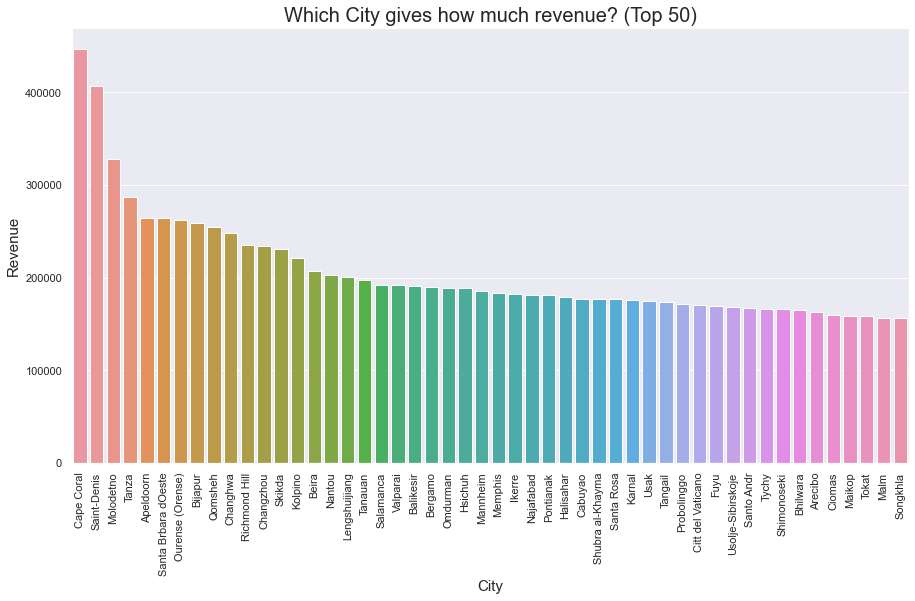

In [345]:
# figure(figsize = (15,6))
fig, ax = plt.subplots(figsize=(15, 8))
a = df8.groupby(['city'])['revenue'].sum().nlargest(50).reset_index()
sns.barplot(x= a.city, y = a.revenue)
ax.set_xticklabels(labels = a.city,rotation =90)
plt.title('Which City gives how much revenue? (Top 50)', fontdict = {'fontsize':20})
plt.xlabel('City', fontdict = {'fontsize':15})
plt.ylabel('Revenue', fontdict = {'fontsize':15})
# labels = df8.groupby(['city'])['revenue'].sum().nlargest(50).reset_index().index


#### City with highest revenue is "Cape Coral"

Text(0.5, 1.0, 'Per Film Category Revenue Generated')

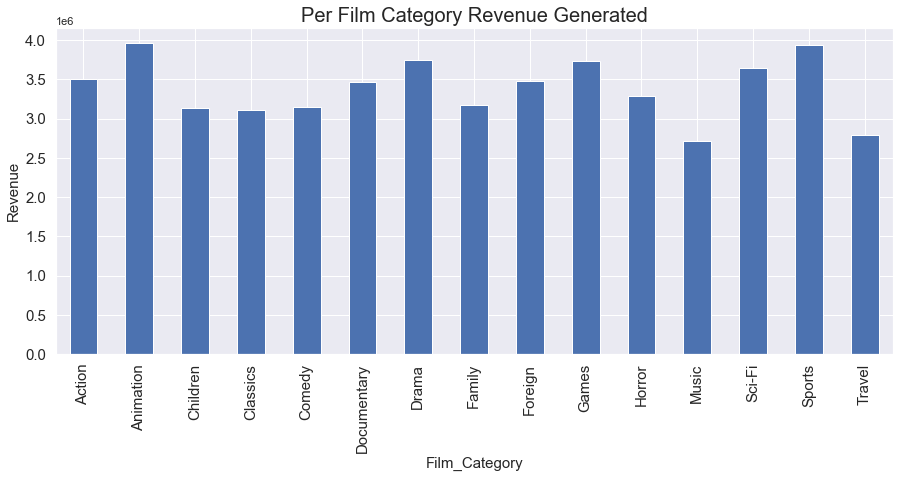

In [340]:
figure(figsize =(15,6))
df8.groupby(['film_category'])['revenue'].sum().plot(kind = 'bar', fontsize = 15)
plt.xlabel('Film_Category', fontdict = {'fontsize':15})
plt.ylabel('Revenue', fontdict = {'fontsize':15})
plt.title('Per Film Category Revenue Generated', fontdict = {'fontsize':20})

#### Highest Revenue generated category is "Action"  at "$3500489" in 2006 year

In [323]:
b = df8.groupby(['film_category'])['revenue'].sum().reset_index()

Text(0.5, 1.0, 'Film Categories generating revenue')

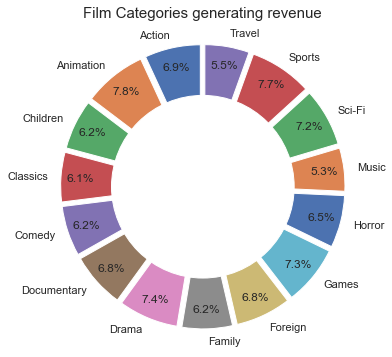

In [339]:
figure(figsize = (12,6))
labels = b.film_category
sizes = b.revenue
explode = (0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Film Categories generating revenue', fontdict = {'fontsize':15})

In [346]:
cur.close()